<a href="https://colab.research.google.com/github/jbastian9/SeminarioBigData/blob/main/Copia_de_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b5b09df303a6dcb4e641ec983efc01364bb82fa5d4698ad88132f66f75e2df51
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


El archivo CSV presenta errores de formato al intentar separar los datos utilizando el delimitador ",". Por esta razón, decidimos utilizar un RDD con un split por coma para cada elemento del CSV.

Cargar el archivo como un Resilient Distributed Dataset (RDD) nos permite manipular el contenido del archivo a un nivel más bajo que utilizando un DataFrame. Esto puede ser útil cuando el archivo tiene problemas de formato, como es nuestro caso actual.

Es importante tener en cuenta que al convertir el archivo CSV en un TXT y usar un split por ",", este método podría no ser útil si la información incluye campos como "observaciones" u otros tipos de contenido que puedan contener comas.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import Row

# Iniciar una sesión de Spark
spark = SparkSession.builder.appName("LimpiezaDeDatos").getOrCreate()

# Ruta del archivo CSV
ruta_archivo = "/content/drive/MyDrive/Colab Notebooks/data/Copia de housing_fincaraiz.csv"

# Cargar el archivo como un RDD
rdd = spark.sparkContext.textFile(ruta_archivo)

# Separar el encabezado del resto de los datos
encabezado = rdd.first()
datos = rdd.filter(lambda x: x != encabezado)

# Dividir el encabezado y las filas por comas
columnas = encabezado.split(',')

# Asegurarse de que la longitud de los nombres de las columnas coincide con la cantidad de datos en cada fila
def parsear_fila(fila):
    elementos = fila.split(',')
    if len(elementos) == len(columnas):
        return Row(*elementos)
    else:
        return None

# Parsear las filas y filtrar las que no se pueden parsear correctamente
filas_parsedas = datos.map(parsear_fila).filter(lambda x: x is not None)

# Crear el DataFrame a partir del RDD
df = spark.createDataFrame(filas_parsedas, schema=columnas)

# Nuevos nombres de columnas
nuevos_nombres_columnas = [
    "habitaciones", "baños", "parqueaderos", "area_construida", "area_privada", "estrato",
    "estado", "antiguedad", "administracion", "precio_m2", "ascensor", "circuito_cerrado_de_TV",
    "parqueadero_visitantes", "porteria_recepcion", "zonas_verdes", "salon_comunal", "balcon",
    "barra_estilo_americano", "calentador", "chimenea", "citofono", "cocina_integral", "terraza",
    "vigilancia", "parques_cercanos", "estudio", "patio", "deposito_bodega", "nombre", "ubicacion", "precio"
]

# Validación de la cantidad de columnas
if len(columnas) != len(nuevos_nombres_columnas):
    print("The number of columns does not match. Adjust the new_column_names list.")
    print(f"Original Columns ({len(columnas)}): {columnas}")
    print(f"New Column Names ({len(nuevos_nombres_columnas)}): {nuevos_nombres_columnas}")
else:
    # Renombrar las columnas del DataFrame
    df = df.toDF(*nuevos_nombres_columnas)
    # Mostrar todos los datos en forma de tabla
    df.show(truncate=False)


+------------+-----+------------+---------------+------------+-------+-----------+--------------+---------------+--------------+--------+----------------------+----------------------+------------------+------------+-------------+------+----------------------+----------+--------+--------+---------------+-------+----------+----------------+-------+-----+---------------+-----------+--------------------+----------+
|habitaciones|baños|parqueaderos|area_construida|area_privada|estrato|estado     |antiguedad    |administracion |precio_m2     |ascensor|circuito_cerrado_de_TV|parqueadero_visitantes|porteria_recepcion|zonas_verdes|salon_comunal|balcon|barra_estilo_americano|calentador|chimenea|citofono|cocina_integral|terraza|vigilancia|parques_cercanos|estudio|patio|deposito_bodega|nombre     |ubicacion           |precio    |
+------------+-----+------------+---------------+------------+-------+-----------+--------------+---------------+--------------+--------+----------------------+----------

In [ ]:
from pyspark.sql.functions import col, regexp_replace, lower
import unicodedata

# Limpiar espacios en blanco al final y convertir a minúsculas
df_cleaned = df.select([
    lower(regexp_replace(col(column), '\s+$', '')).alias(column) for column in df.columns
])

# Aplicar limpieza específica para las columnas de precios y áreas
df_cleaned = df_cleaned.withColumn('precio_m2', regexp_replace('precio_m2', '[^\d]', ''))
df_cleaned = df_cleaned.withColumn('administracion', regexp_replace('administracion', '[^\d]', ''))
df_cleaned = df_cleaned.withColumn('precio', regexp_replace('precio', '[^\d]', ''))

# Convertir las columnas de áreas a números eliminando el indicador de m²
df_cleaned = df_cleaned.withColumn('area_construida', regexp_replace('area_construida', '[^\d]', ''))
df_cleaned = df_cleaned.withColumn('area_privada', regexp_replace('area_privada', '[^\d]', ''))

# Mostrar la tabla limpia
df_cleaned.show(truncate=False)


+------------+-----+------------+---------------+------------+-------+-----------+--------------+--------------+---------+--------+----------------------+----------------------+------------------+------------+-------------+------+----------------------+----------+--------+--------+---------------+-------+----------+----------------+-------+-----+---------------+-----------+--------------------+----------+
|habitaciones|baños|parqueaderos|area_construida|area_privada|estrato|estado     |antiguedad    |administracion|precio_m2|ascensor|circuito_cerrado_de_TV|parqueadero_visitantes|porteria_recepcion|zonas_verdes|salon_comunal|balcon|barra_estilo_americano|calentador|chimenea|citofono|cocina_integral|terraza|vigilancia|parques_cercanos|estudio|patio|deposito_bodega|nombre     |ubicacion           |precio    |
+------------+-----+------------+---------------+------------+-------+-----------+--------------+--------------+---------+--------+----------------------+----------------------+-----

  # **Recolectar datos iniciales**

### ¿Qué variables (columnas, atributos) de la(s) tabla(s) o base(s) de datos parecen más prometedores?

Se determinó que las variables más relevantes para el análisis de precios de vivienda son:

- **Precio:** Representa el valor monetario de la propiedad, siendo el principal objetivo del estudio.
- **Área construida:** Influye directamente en el precio, ya que propiedades con mayor área construida suelen tener valores más altos.
- **Ubicación:** Factor crucial que afecta significativamente el valor de la propiedad debido a la influencia de la zona, servicios y seguridad.
- **Estrato:** En algunos contextos, el estrato socioeconómico de la propiedad puede impactar considerablemente en su valoración.
- **Estado:** La condición general de la propiedad (bueno, excelente, etc.) afecta su atractivo y valor en el mercado.
- **Antigüedad:** La edad de la propiedad puede influir en su valoración, con propiedades más nuevas a menudo siendo más valoradas.
- **Administración:** Costo mensual de administración, relevante para compradores e inversores por su impacto en los costos operativos.
- **Habitaciones y baños:** Indicativos del tamaño y comodidad de la propiedad, influyendo en su atractivo y valorización.

Estas variables fueron identificadas como las más prometedoras debido a su capacidad para explicar variaciones en los precios de las propiedades y su importancia en la toma de decisiones en el mercado inmobiliario.


In [ ]:
# Seleccionar solo las columnas relevantes
columnas_relevantes = [
    "precio", "area_construida", "ubicacion", "estrato", "estado",
    "antiguedad", "administracion", "habitaciones", "baños"
]

# Mostrar la tabla limpia con las columnas seleccionadas
df_cleaned.select(columnas_relevantes).show(truncate=False)


+----------+---------------+--------------------+-------+-----------+--------------+--------------+------------+-----+
|precio    |area_construida|ubicacion           |estrato|estado     |antiguedad    |administracion|habitaciones|baños|
+----------+---------------+--------------------+-------+-----------+--------------+--------------+------------+-----+
|340000000 |50             |contador            |5      |bueno      |9 a 15 años   |310000        |1           |2    |
|360000000 |90             |cedro golf          |4      |bueno      |más de 30 años|369000        |4           |3    |
|2898000000|322            |los rosales         |6      |no definida|1 a 8 años    |2304000       |2           |3    |
|315000000 |75             |mazurén             |4      |excelente  |16 a 30 años  |316000        |2           |2    |
|500000000 |100            |colina campestre    |5      |bueno      |16 a 30 años  |440000        |3           |2    |
|330000000 |120            |nuevo techo         

### ¿Qué variables parecen irrelevantes y pueden ser excluidas?

Se determinó que las variables menos relevantes y que pueden ser excluidas del análisis son:

- **Parqueadero_visitantes:** Esta variable indica la disponibilidad de parqueadero para visitantes, pero no tiene un impacto directo en la valoración de la propiedad.
- **Circuito_cerrado_de_TV:** Indica si el lugar cuenta con circuito cerrado de televisión, un factor de seguridad que no influye significativamente en el precio de la propiedad.
- **Estudio:** Variable que indica la presencia de un estudio en la propiedad, aunque no es crucial para determinar su valor en el mercado.
- **Barra_estilo_americano:** Indica si la cocina tiene una barra estilo americano, un detalle que no influye considerablemente en la valoración de la propiedad.
- **Zonas_verdes:** Indica la presencia de áreas verdes cercanas, pero no tiene un impacto directo en el precio de venta o arriendo de la propiedad.

Estas variables fueron identificadas como menos relevantes porque su impacto en la valoración de las propiedades es menos significativo en comparación con otras variables como el precio, área construida, ubicación y estado general de la propiedad.


In [ ]:
# Seleccionar solo las columnas irrelevantes
columnas_irrelevantes = [
    "parqueadero_visitantes", "circuito_cerrado_de_TV", "estudio",
    "barra_estilo_americano", "zonas_verdes"
]

# Mostrar la tabla limpia excluyendo las columnas irrelevantes
df_cleaned.drop(*columnas_irrelevantes).show(truncate=False)

# Mostrar la tabla con las columnas irrelevantes
df_cleaned.select(columnas_irrelevantes).show(truncate=False)


+------------+-----+------------+---------------+------------+-------+-----------+--------------+--------------+---------+--------+------------------+-------------+------+----------+--------+--------+---------------+-------+----------+----------------+-----+---------------+-----------+--------------------+----------+
|habitaciones|baños|parqueaderos|area_construida|area_privada|estrato|estado     |antiguedad    |administracion|precio_m2|ascensor|porteria_recepcion|salon_comunal|balcon|calentador|chimenea|citofono|cocina_integral|terraza|vigilancia|parques_cercanos|patio|deposito_bodega|nombre     |ubicacion           |precio    |
+------------+-----+------------+---------------+------------+-------+-----------+--------------+--------------+---------+--------+------------------+-------------+------+----------+--------+--------+---------------+-------+----------+----------------+-----+---------------+-----------+--------------------+----------+
|1           |2    |1           |50        

### ¿Hay suficientes datos para sacar conclusiones generalizables o hacer predicciones precisas?

Basado en la cantidad y calidad de los datos disponibles, se dispone de suficiente información para realizar análisis exploratorios y modelado predictivo inicial.


### ¿Hay demasiadas variables para el método de modelado de su elección?

Dado que estamos utilizando Regresión Lineal y seleccionamos 8 variables como relevantes, se considera que hay suficientes datos para manejar. Sin embargo, debemos asegurarnos de que estas variables realmente influyan en la predicción final y no sobrecargar el modelo con información innecesaria.

### ¿Está fusionando varias fuentes de datos? Si es así, ¿hay áreas que podrían plantear un problema al fusionar?

No, todos los datos provienen de la misma fuente, el archivo csv obtenido

### ¿Ha considerado cómo se manejan los valores que faltan en cada uno de sus orígenes de
datos?

Sí, se han considerado los valores faltantes en los datos. En la muestra proporcionada por el visualizador anterior, se observa que las columnas "administracion" y "antiguedad" contienen valores nulos. Para manejarlos adecuadamente, se planea imputar estos valores utilizando técnicas estadísticas como la media o la mediana, asegurando que el proceso de imputación no afecte negativamente la calidad del modelo de regresión lineal. Esto es crucial para mantener la precisión de las predicciones sobre los precios de las propiedades.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType

# Definir función para calcular la mediana
def median(df, col):
    return df.approxQuantile(col, [0.5], 0.25)[0]

# Convertir columnas relevantes a tipos numéricos si es necesario
df_cleaned = df_cleaned.withColumn("administracion", df_cleaned["administracion"].cast(IntegerType()))
df_cleaned = df_cleaned.withColumn("precio", df_cleaned["precio"].cast(DoubleType()))

# Imputar valores nulos o ceros con la mediana de columnas numéricas
for col_name in ["precio", "administracion"]:
    if col_name in df_cleaned.columns:  # Verificar que la columna exista
        median_value = median(df_cleaned, col_name)
        df_cleaned = df_cleaned.withColumn(col_name, F.when((F.col(col_name).isNull()) | (F.col(col_name) == 0), median_value).otherwise(F.col(col_name)))
        print(f"Valor imputado para '{col_name}': {median_value}")

# Mostrar la tabla limpia con las columnas seleccionadas y formato adecuado para precio
df_cleaned.select("precio", "area_construida", "ubicacion", "estrato", "estado", "antiguedad", "administracion", "habitaciones", "baños") \
  .withColumn("precio", F.format_number("precio", 0)) \
  .show(truncate=False)


Valor imputado para 'precio': 315000000.0
Valor imputado para 'administracion': 220000.0
+-------------+---------------+--------------------+-------+-----------+--------------+--------------+------------+-----+
|precio       |area_construida|ubicacion           |estrato|estado     |antiguedad    |administracion|habitaciones|baños|
+-------------+---------------+--------------------+-------+-----------+--------------+--------------+------------+-----+
|340,000,000  |50             |contador            |5      |bueno      |9 a 15 años   |310000.0      |1           |2    |
|360,000,000  |90             |cedro golf          |4      |bueno      |más de 30 años|369000.0      |4           |3    |
|2,898,000,000|322            |los rosales         |6      |no definida|1 a 8 años    |2304000.0     |2           |3    |
|315,000,000  |75             |mazurén             |4      |excelente  |16 a 30 años  |316000.0      |2           |2    |
|500,000,000  |100            |colina campestre    |5    

# Describir los datos

### ¿Cuál es el formato de los datos?

El formato de los datos que hemos estado manipulando, es principalmente estructurado. Esto significa que los datos están organizados en filas y columnas, donde cada columna tiene un tipo de datos específico como entero, decimal, cadena de texto, etc.


### ¿Cuál es el método utilizado para capturar los datos?
El método utilizado para capturar los datos fue a través de la carga de un archivo CSV.

### ¿Qué tamaño tiene la base de datos (en número de filas y columnas)?

In [ ]:
# Cargar el archivo CSV como un DataFrame
df0 = spark.read.option("header", "true").csv(ruta_archivo)

# Obtener el tamaño del DataFrame (número de filas y columnas)
num_filas = df0.count()
num_columnas = len(df0.columns)

# Imprimir el tamaño del DataFrame CSV
print(f"Tamaño del DataFrame CSV: {num_filas} filas y {num_columnas} columnas.")

# Imprimir tamaño del DataFrame original (df)
num_filas_df = df.count()
num_columnas_df = len(df.columns)
print(f"Tamaño del DataFrame original (df): {num_filas_df} filas y {num_columnas_df} columnas.")

# Imprimir tamaño del DataFrame limpio (df_cleaned)
num_filas_cleaned = df_cleaned.count()
num_columnas_cleaned = len(df_cleaned.columns)
print(f"Tamaño del DataFrame limpio (df_cleaned): {num_filas_cleaned} filas y {num_columnas_cleaned} columnas.")


Tamaño del DataFrame CSV: 8428 filas y 31 columnas.
Tamaño del DataFrame original (df): 8428 filas y 31 columnas.
Tamaño del DataFrame limpio (df_cleaned): 1228 filas y 31 columnas.


### ¿Incluyen los datos una o más variables relevantes para la pregunta de negocio?

Si, si nos enfocamos en predecir o analizar precios de mercado para finca raiz


In [ ]:
# Imprimir el esquema del DataFrame
df_cleaned.printSchema()

# Mostrar una vista previa de los datos
df_cleaned.show(5)


root
 |-- habitaciones: string (nullable = true)
 |-- baños: string (nullable = true)
 |-- parqueaderos: string (nullable = true)
 |-- area_construida: string (nullable = true)
 |-- area_privada: string (nullable = true)
 |-- estrato: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- antiguedad: string (nullable = true)
 |-- administracion: double (nullable = true)
 |-- precio_m2: string (nullable = true)
 |-- ascensor: string (nullable = true)
 |-- circuito_cerrado_de_TV: string (nullable = true)
 |-- parqueadero_visitantes: string (nullable = true)
 |-- porteria_recepcion: string (nullable = true)
 |-- zonas_verdes: string (nullable = true)
 |-- salon_comunal: string (nullable = true)
 |-- balcon: string (nullable = true)
 |-- barra_estilo_americano: string (nullable = true)
 |-- calentador: string (nullable = true)
 |-- chimenea: string (nullable = true)
 |-- citofono: string (nullable = true)
 |-- cocina_integral: string (nullable = true)
 |-- terraza: string (nul

### ¿Qué tipos de datos están presentes (simbólicos, numéricos, etc.)?

Según las directrices de IBM, el formato de los datos en el conjunto actual incluye principalmente:

1. **Valores Numéricos:** Utilizados para variables como `precio`, `area_construida`, `estrato`, `administracion`, `habitaciones`, y `baños`. Estos valores son representaciones numéricas de atributos específicos de las propiedades.

2. **Valores Categóricos:** Representados como cadenas de texto en variables como `ubicacion`, `estado`, y `antiguedad`. Estos campos describen características tales como la ubicación geográfica de las propiedades, su estado general y su antigüedad.

In [ ]:
# Mostrar los tipos de datos de cada columna en el DataFrame
print(df_cleaned.dtypes)

[('habitaciones', 'string'), ('baños', 'string'), ('parqueaderos', 'string'), ('area_construida', 'string'), ('area_privada', 'string'), ('estrato', 'string'), ('estado', 'string'), ('antiguedad', 'string'), ('administracion', 'double'), ('precio_m2', 'string'), ('ascensor', 'string'), ('circuito_cerrado_de_TV', 'string'), ('parqueadero_visitantes', 'string'), ('porteria_recepcion', 'string'), ('zonas_verdes', 'string'), ('salon_comunal', 'string'), ('balcon', 'string'), ('barra_estilo_americano', 'string'), ('calentador', 'string'), ('chimenea', 'string'), ('citofono', 'string'), ('cocina_integral', 'string'), ('terraza', 'string'), ('vigilancia', 'string'), ('parques_cercanos', 'string'), ('estudio', 'string'), ('patio', 'string'), ('deposito_bodega', 'string'), ('nombre', 'string'), ('ubicacion', 'string'), ('precio', 'double')]


### ¿Ha calculado estadísticas básicas para las variables clave? ¿Qué información le ha proporcionado sobre la cuestión de negocio?

Para calcular estadísticas básicas para las variables clave del conjunto de datos y obtener información relevante para la pregunta de negocio, utilizamnos funciones estadísticas disponibles en Spark como describe() y summary(). Estas funciones proporcionan un resumen estadístico que incluye el recuento de registros, la media, la desviación estándar, los valores mínimo y máximo, y los cuartiles para las columnas numéricas.

In [ ]:
# Importar funciones de Spark SQL
from pyspark.sql import functions as F

# Calcular estadísticas básicas para las variables clave
df_cleaned.select("precio", "area_construida", "estrato", "administracion", "habitaciones", "baños") \
    .describe() \
    .show(truncate=False)



+-------+-------------------+------------------+------------------+--------------------+------------------+------------------+
|summary|precio             |area_construida   |estrato           |administracion      |habitaciones      |baños             |
+-------+-------------------+------------------+------------------+--------------------+------------------+------------------+
|count  |1228               |1228              |1228              |1228                |1228              |1228              |
|mean   |7.088844186726384E8|133.32247557003257|4.257328990228013 |1066635.690553746   |3.122549019607843 |2.616830065359477 |
|stddev |7.392032811774138E8|122.39983613402062|1.2647448335372662|2.1395207257076625E7|1.7208304026784156|1.2804886193861416|
|min    |6.0E7              |1                 |1                 |1.0                 |1                 |1                 |
|max    |9.8E9              |98                |6                 |7.5E8               |no definida       |no d

### ¿Es capaz de priorizar las variables relevantes? Si no es así, ¿hay analistas de negocio disponibles para proporcionar más información?

sería recomendable consultar con analistas de negocio disponibles. Ellos pueden ofrecer una perspectiva experta sobre qué variables son más críticas para abordar la pregunta de negocio específica, ayudando así a centrar el análisis en los factores que más impactan en los resultados deseados.

# Explorar los datos

### ¿Qué tipo de hipótesis se ha formado sobre los datos?

Respecto a las hipótesis que se pueden formular sobre los datos, estas pueden incluir:



1.   Distribución de precios: Hipótesis sobre la distribución de los precios de las propiedades, por ejemplo, si siguen una distribución normal o están sesgados hacia un rango específico.
2.   Relación entre variables: Hipótesis sobre la relación entre el precio de las propiedades y variables como el área construida, la ubicación, el estrato socioeconómico, entre otros.
3.  Impacto de características específicas: Hipótesis sobre cómo características como el estado de la propiedad, la antigüedad, o la presencia de amenidades (como ascensor, vigilancia, etc.) afectan el precio.

### ¿Qué variables parecen prometedoras para un análisis más profundo?

las variables que parecen más prometedoras para un análisis más profundo del precio de las viviendas son:

1. Precio: Es la variable objetivo principal del estudio y representa el valor monetario de la propiedad.
2. Área construida: Esta variable influye directamente en el precio de las propiedades, ya que generalmente propiedades con mayor área construida tienden a tener valores más altos.
3. Ubicación: Es un factor crucial que afecta significativamente el valor de la propiedad debido a la influencia de la zona, servicios disponibles y nivel de seguridad.
4. Estrato: En algunos contextos, el estrato socioeconómico de la propiedad puede impactar considerablemente en su valoración.
5. Estado: La condición general de la propiedad (bueno, excelente, etc.) afecta su atractivo y valor en el mercado inmobiliario.
6. Antigüedad: La edad de la propiedad puede influir en su valoración, con propiedades más nuevas a menudo siendo más valoradas.
7. Administración: El costo mensual de administración es relevante para compradores e inversores debido a su impacto en los costos operativos.
8. Habitaciones y baños: Estos atributos son indicativos del tamaño y comodidad de la propiedad, lo cual influye en su atractivo y valorización.

### ¿Sus exploraciones han revelado nuevas características sobre los datos?

In [31]:
# Seleccionar columnas numéricas para calcular estadísticas descriptivas
columnas_numericas = ["precio", "area_construida", "estrato", "administracion", "habitaciones", "baños"]

# Calcular estadísticas descriptivas
df_cleaned.select(columnas_numericas).describe().show(truncate=False)


+-------+-------------------+------------------+------------------+--------------------+------------------+------------------+
|summary|precio             |area_construida   |estrato           |administracion      |habitaciones      |baños             |
+-------+-------------------+------------------+------------------+--------------------+------------------+------------------+
|count  |1228               |1228              |1228              |1228                |1228              |1228              |
|mean   |7.088844186726384E8|133.32247557003257|4.257328990228013 |1066635.690553746   |3.122549019607843 |2.616830065359477 |
|stddev |7.392032811774138E8|122.39983613402062|1.2647448335372662|2.1395207257076625E7|1.7208304026784156|1.2804886193861416|
|min    |6.0E7              |1                 |1                 |1.0                 |1                 |1                 |
|max    |9.8E9              |98                |6                 |7.5E8               |no definida       |no d

Resultados de las estadísticas descriptivas:

- **Precio**: El precio promedio de las propiedades es aproximadamente 708 millones de pesos colombianos (COP), con una desviación estándar de aproximadamente 739 millones COP. El rango de precios va desde 60 millones COP hasta 9.8 mil millones COP.

- **Área Construida**: La media del área construida es de alrededor de 133 metros cuadrados, con una desviación estándar de aproximadamente 122 metros cuadrados. El área mínima registrada es de 1 metro cuadrado y el máximo es de 98 metros cuadrados.

- **Estrato**: La mayoría de las propiedades están concentradas en estratos entre 1 y 6, con un promedio de estrato de aproximadamente 4.26.

- **Administración**: El valor promedio de la administración es de aproximadamente 1,066,635 COP, con una desviación estándar muy alta de alrededor de 21,395,207 COP. Esto sugiere una variabilidad considerable en los costos de administración de las propiedades.

- **Habitaciones y Baños**: En promedio, las propiedades tienen alrededor de 3.12 habitaciones y 2.62 baños.


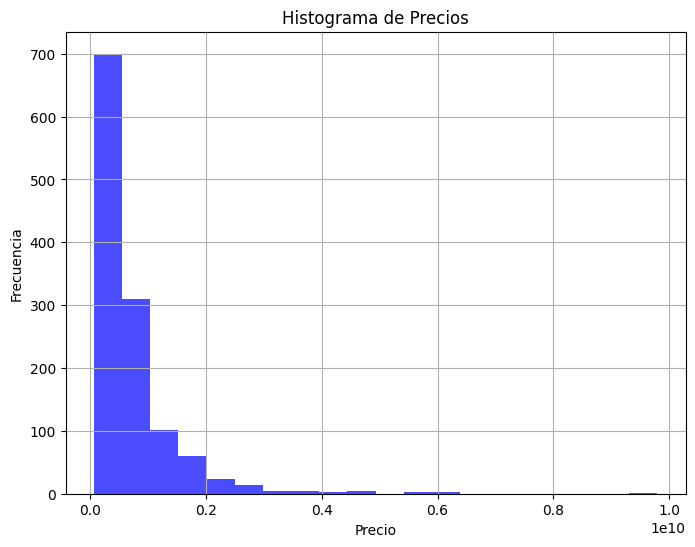

In [32]:
import matplotlib.pyplot as plt

# Convertir el DataFrame de Spark a Pandas para visualización con matplotlib
df_pd = df_cleaned.select(columnas_numericas).toPandas()

# Histograma de precios
plt.figure(figsize=(8, 6))
plt.hist(df_pd['precio'], bins=20, color='blue', alpha=0.7)
plt.title('Histograma de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

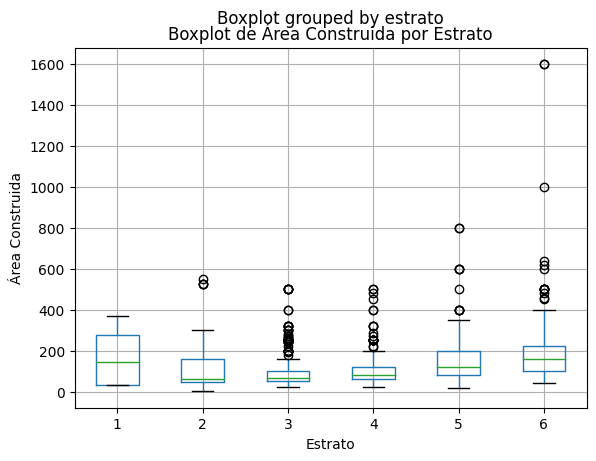

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Convertir el DataFrame de PySpark a Pandas para visualización con matplotlib
df_pd = df_cleaned.select(["area_construida", "estrato"]).toPandas()

# Convertir columnas numéricas de strings a numéricas
df_pd["area_construida"] = pd.to_numeric(df_pd["area_construida"], errors='coerce')

# Boxplot de área construida por estrato
plt.figure(figsize=(10, 6))
df_pd.boxplot(column='area_construida', by='estrato')
plt.title('Boxplot de Área Construida por Estrato')
plt.xlabel('Estrato')
plt.ylabel('Área Construida')
plt.grid(True)
plt.show()




### ¿Cómo han cambiado estas exploraciones su hipótesis inicial?
Estas exploraciones han cambiado la hipótesis inicial al proporcionar evidencia concreta sobre la distribución de los datos según el estrato. Inicialmente, podría haber una expectativa de que todos los estratos tengan una distribución uniforme o que ciertos estratos extremos (como 1, 2, 5 y 6) podrían tener una influencia significativa en los análisis. Sin embargo, los resultados del boxplot indican que los estratos 3 y 4 son donde se concentra la mayor cantidad de observaciones, mostrando una distribución más equilibrada y posiblemente más representativa del conjunto de datos.

Este cambio en la perspectiva inicial sugiere que para análisis posteriores, enfocarse en los estratos 3 y 4 podría proporcionar una visión más precisa y significativa de las tendencias y patrones relacionados con las propiedades inmobiliarias en este conjunto de datos específico.

### ¿Considera que debería reformular el alcance del proyecto?

Si las exploraciones han revelado que ciertos estratos (como 3 y 4) son más representativos y relevantes para el análisis de propiedades inmobiliarias, podría ser beneficioso ajustar el alcance del proyecto para enfocarse específicamente en esos estratos.

### ¿Esta exploración ha alterado los objetivos?

La exploración detallada de los datos, especialmente al identificar que los estratos 3 y 4 son más representativos y relevantes para el análisis de propiedades inmobiliarias, podría justificar una revisión de los objetivos del proyecto. Si inicialmente se planeó un análisis general de todos los estratos y ahora se observa que los estratos 3 y 4 son cruciales, los objetivos podrían reformularse para enfocarse específicamente en estos estratos. Esto podría implicar ajustar los objetivos para explorar cómo las características específicas de las propiedades en estos estratos afectan el precio, la demanda o cualquier otra métrica relevante.

### ¿Puede identificar subconjuntos particulares de datos para su uso posterior?

Sí, con base en la exploración de datos, es posible identificar subconjuntos específicos de datos que son más relevantes para el análisis. En este caso, los subconjuntos podrían ser todas las propiedades ubicadas en los estratos 3 y 4.